In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)>
  data = fetch_version_info()


In [2]:
class Config:
    img_size = 224
    batch_size = 8
    lr = 5e-5
    epochs = 50
    img_dir = "D:/Leko/medical_model/task2/data/images"  # 图像路径
    mask_dir = "D:/Leko/medical_model/task2/data/masks"   # 掩码路径
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    saved_model_dir = "D:\\Leko\\medical_model\\task2\\model"
    best_model_name = "UnetppResnet34.pth"

In [3]:
class MedicalSegmentationDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, transform=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        name, _ = os.path.splitext(img_name)   # 拿到 "image_001"
        mask_name = f"{name}_mask.png"          # 加上 _mask.png
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask


In [ ]:
def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    intersection = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def plot_history(history):
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['val_dice'], label='Val Dice')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.legend()
    plt.title('Validation Metrics')
    plt.grid(True)

    plt.show()

def save_metrics_to_csv(history, save_path="D:/Leko/medical_model/task2/modeltraining_metrics.csv"):
    df = pd.DataFrame({
        "Train Loss": history["train_loss"],
        "Val Loss": history["val_loss"],
        "Val Dice": history["val_dice"],
        "Val IoU": history["val_iou"],
    })
    df.to_csv(save_path, index=False)
    print(f" 训练指标已保存到 {save_path}")


def apply_cutmix_mixup(imgs, masks, alpha=1.0, cutmix_prob=0.5, mixup_prob=0.5):
    batch_size = imgs.size(0)
    
    # --- 随机决定使用哪种增强 ---
    rand_val = random.random()
    
    if rand_val < cutmix_prob:
        # CutMix
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(batch_size).to(imgs.device)
        
        bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
        imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
        masks[:, :, bbx1:bbx2, bby1:bby2] = masks[rand_index, :, bbx1:bbx2, bby1:bby2]
        
    elif rand_val < cutmix_prob + mixup_prob:
        # MixUp
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(batch_size).to(imgs.device)
        
        imgs = imgs * lam + imgs[rand_index] * (1 - lam)
        masks = masks * lam + masks[rand_index] * (1 - lam)

    else:
        # 什么都不做，直接返回
        pass

    return imgs, masks

# --- CutMix的辅助函数 ---
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



In [ ]:
def show_samples(dataset, num_samples=4, title="Samples"):
    plt.figure(figsize=(12, num_samples * 3))

    for i in range(num_samples):
        img, mask = dataset[i]
        img = img.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        mask = mask.squeeze().cpu().numpy()       # (1, H, W) -> (H, W)

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean).clip(0, 1)

        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(f"{title} Image {i+1}")
        plt.axis("off")

        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"{title} Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

训练集数量: 240
验证集数量: 30


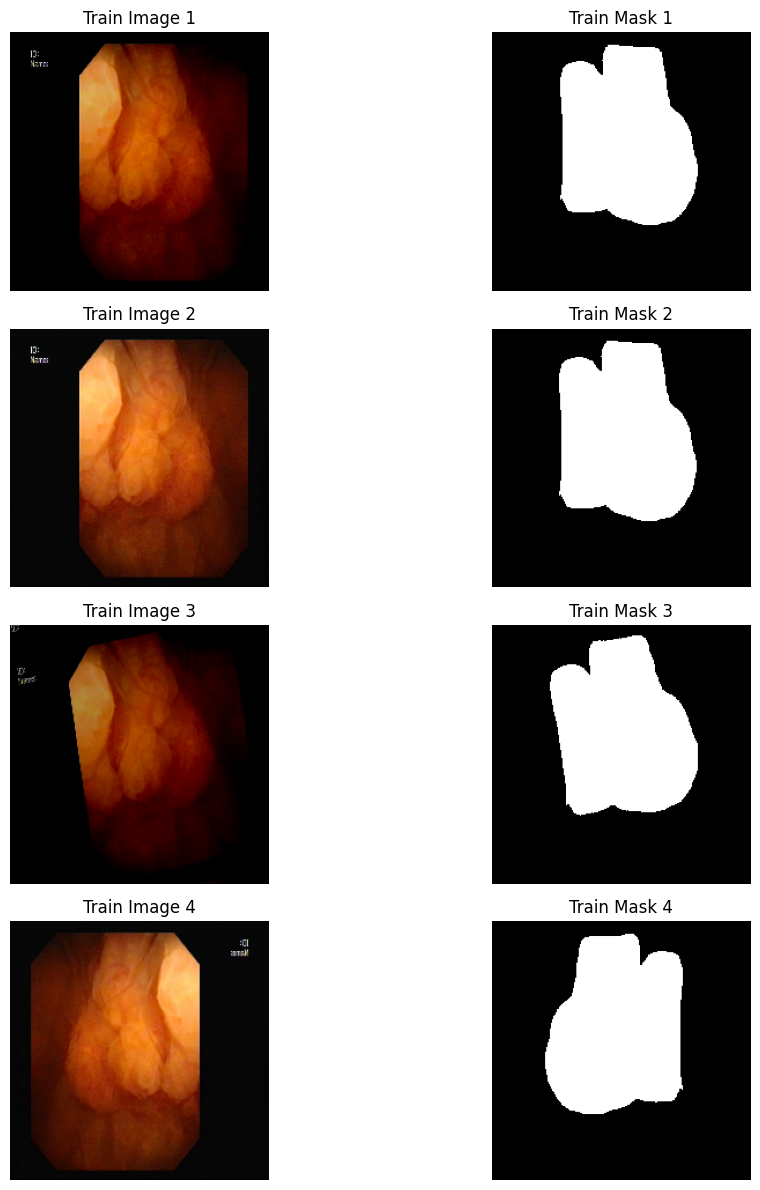

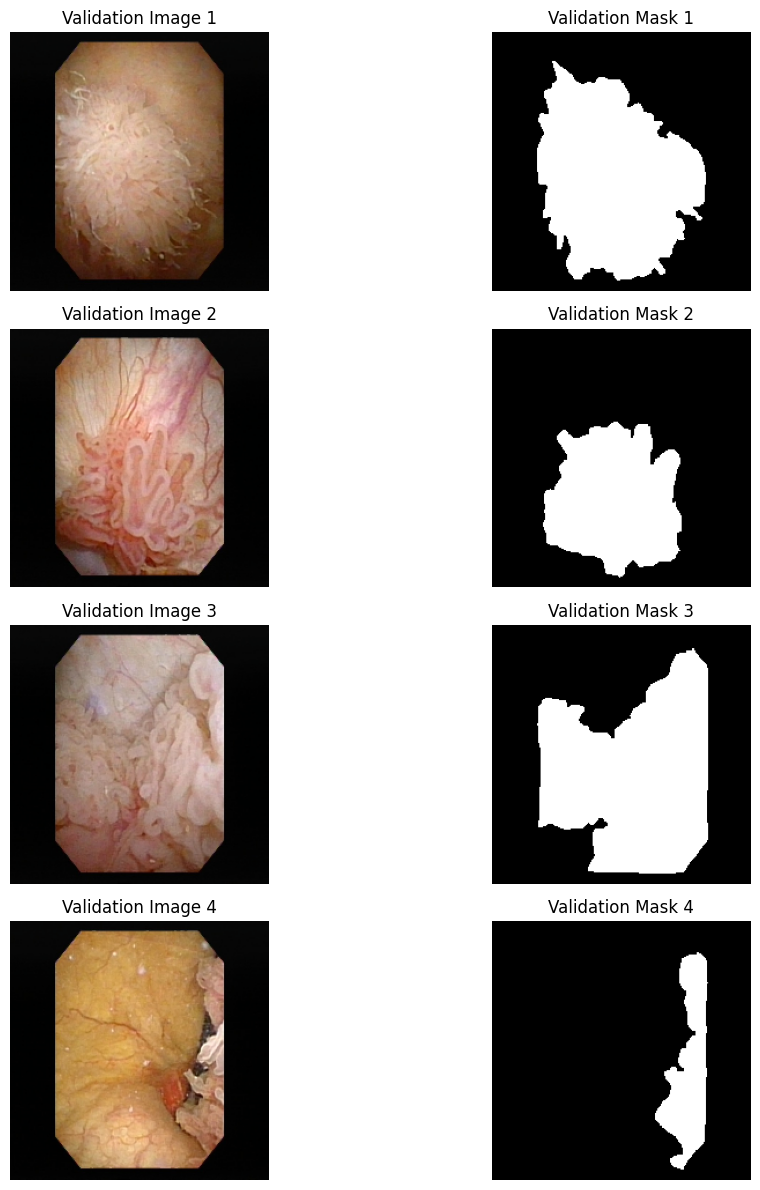

In [ ]:
all_images = sorted([
    f for f in os.listdir(Config.img_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

train_files = all_images[:240]
val_files = all_images[240:]

print(f"训练集数量: {len(train_files)}")
print(f"验证集数量: {len(val_files)}")

train_transform = A.Compose([
    A.Resize(Config.img_size, Config.img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(Config.img_size, Config.img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


train_dataset = MedicalSegmentationDataset(train_files, Config.img_dir, Config.mask_dir, train_transform)
val_dataset = MedicalSegmentationDataset(val_files, Config.img_dir, Config.mask_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)

show_samples(train_dataset, num_samples=4, title="Train")
show_samples(val_dataset, num_samples=4, title="Validation")


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


🎯 Epoch 1: Val Dice=0.6913, Val IoU=0.5878, Val Loss=0.7322
✅ 保存了新的最优模型


Epoch 2/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/50: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


🎯 Epoch 2: Val Dice=0.7327, Val IoU=0.6336, Val Loss=0.6620
✅ 保存了新的最优模型


Epoch 3/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/50: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


🎯 Epoch 3: Val Dice=0.7584, Val IoU=0.6571, Val Loss=0.5909
✅ 保存了新的最优模型


Epoch 4/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/50: 100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


🎯 Epoch 4: Val Dice=0.7732, Val IoU=0.6847, Val Loss=0.5556
✅ 保存了新的最优模型


Epoch 5/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/50: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


🎯 Epoch 5: Val Dice=0.7742, Val IoU=0.6823, Val Loss=0.5433
✅ 保存了新的最优模型


Epoch 6/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/50: 100%|██████████| 30/30 [01:04<00:00,  2.14s/it]


🎯 Epoch 6: Val Dice=0.7851, Val IoU=0.6881, Val Loss=0.5139
✅ 保存了新的最优模型


Epoch 7/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/50: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


🎯 Epoch 7: Val Dice=0.7942, Val IoU=0.7059, Val Loss=0.4920
✅ 保存了新的最优模型


Epoch 8/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/50: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


🎯 Epoch 8: Val Dice=0.7868, Val IoU=0.6834, Val Loss=0.5004


Epoch 9/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/50: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


🎯 Epoch 9: Val Dice=0.7786, Val IoU=0.6904, Val Loss=0.4822


Epoch 10/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/50: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


🎯 Epoch 10: Val Dice=0.7782, Val IoU=0.6795, Val Loss=0.4819


Epoch 11/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/50: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


🎯 Epoch 11: Val Dice=0.7980, Val IoU=0.7177, Val Loss=0.4602
✅ 保存了新的最优模型


Epoch 12/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/50: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


🎯 Epoch 12: Val Dice=0.7852, Val IoU=0.6868, Val Loss=0.4694


Epoch 13/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/50: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


🎯 Epoch 13: Val Dice=0.7882, Val IoU=0.6995, Val Loss=0.4436


Epoch 14/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/50: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


🎯 Epoch 14: Val Dice=0.7872, Val IoU=0.6832, Val Loss=0.4609


Epoch 15/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/50: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


🎯 Epoch 15: Val Dice=0.8032, Val IoU=0.7133, Val Loss=0.4387
✅ 保存了新的最优模型


Epoch 16/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/50: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


🎯 Epoch 16: Val Dice=0.7966, Val IoU=0.7020, Val Loss=0.4364


Epoch 17/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/50: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


🎯 Epoch 17: Val Dice=0.7767, Val IoU=0.6901, Val Loss=0.4511


Epoch 18/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/50: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


🎯 Epoch 18: Val Dice=0.7975, Val IoU=0.7157, Val Loss=0.4260


Epoch 19/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/50: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


🎯 Epoch 19: Val Dice=0.7844, Val IoU=0.7031, Val Loss=0.4276


Epoch 20/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/50: 100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


🎯 Epoch 20: Val Dice=0.7990, Val IoU=0.7159, Val Loss=0.4097


Epoch 21/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 21/50: 100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


🎯 Epoch 21: Val Dice=0.7841, Val IoU=0.7027, Val Loss=0.4340


Epoch 22/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 22/50: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


🎯 Epoch 22: Val Dice=0.7903, Val IoU=0.6903, Val Loss=0.4290


Epoch 23/50:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1725877997.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 23/50: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


🎯 Epoch 23: Val Dice=0.7874, Val IoU=0.6997, Val Loss=0.4167
⏹️ Early Stopping triggered at Epoch 23


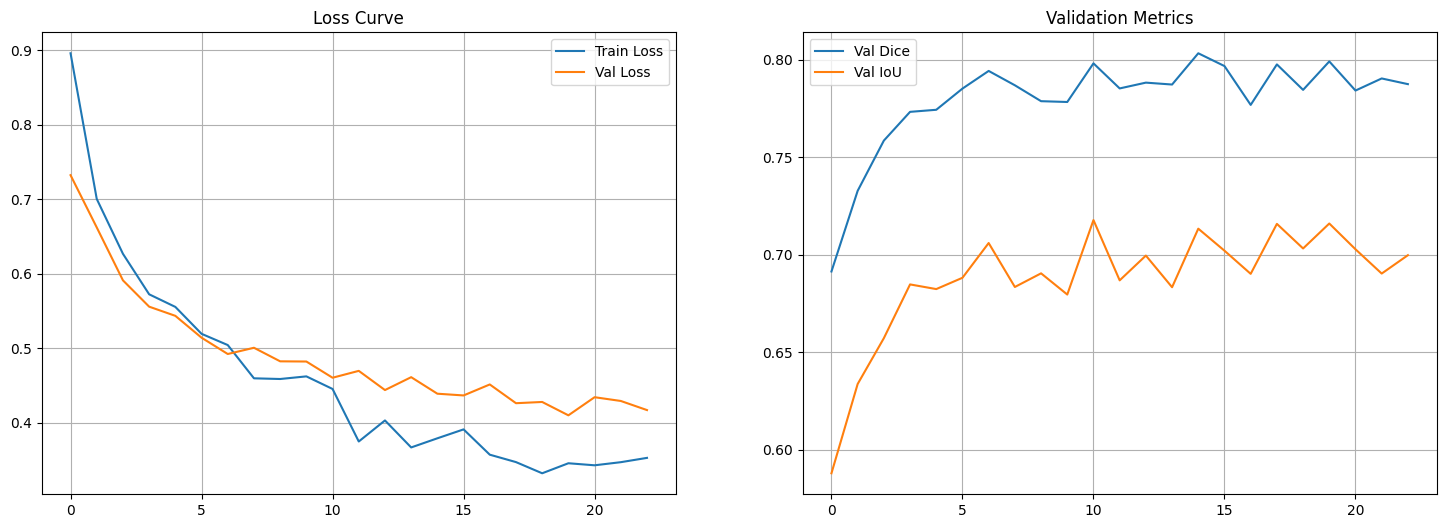

 训练指标已保存到 D:/Leko/medical_model/task2/modeltraining_metrics.csv
🏆 最佳Dice分数: 0.8032


In [ ]:

model = smp.UnetPlusPlus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
    decoder_dropout=0.5
).to(Config.device)


optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
scaler = GradScaler()


history = {"train_loss": [], "val_loss": [], "val_dice": [], "val_iou": []}

best_dice = 0
patience = 8
no_improve = 0

for epoch in range(Config.epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.epochs}")
    cutmix_prob = min(0.5 + 0.01 * epoch, 0.8)  # 每个epoch增加1%，最高到80%
    for imgs, masks in loop:
        imgs, masks = imgs.to(Config.device), masks.to(Config.device).float()
        imgs, masks = apply_cutmix_mixup(imgs, masks, alpha=1.0, cutmix_prob=0.5, mixup_prob=0.5)
        optimizer.zero_grad()

        with autocast():
            preds = model(imgs)
            bce = F.binary_cross_entropy_with_logits(preds, masks)
            dice = dice_loss(preds, masks)
            loss = bce + 0.7 * dice

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    # 验证阶段
    model.eval()
    val_loss = 0
    all_preds, all_gts = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(Config.device), masks.to(Config.device).float()
            preds = model(imgs)
            bce = F.binary_cross_entropy_with_logits(preds, masks)
            dice = dice_loss(preds, masks)
            val_loss += (bce + 0.7 * dice).item()

            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            all_preds.extend(preds.cpu().numpy().reshape(preds.shape[0], -1))
            all_gts.extend(masks.cpu().numpy().reshape(masks.shape[0], -1))

    all_preds = np.array(all_preds)
    all_gts = np.array(all_gts)

    dice_scores = (2 * (all_preds * all_gts).sum(axis=1) + 1e-8) / ((all_preds + all_gts).sum(axis=1) + 1e-8)
    avg_val_dice = dice_scores.mean()
    avg_val_iou = jaccard_score(all_gts.flatten(), all_preds.flatten(), zero_division=0)
    val_avg_loss = val_loss / len(val_loader)  

    history["train_loss"].append(total_loss / len(train_loader))
    history["val_loss"].append(val_avg_loss)
    history["val_dice"].append(avg_val_dice)
    history["val_iou"].append(avg_val_iou)

    print(f"Epoch {epoch+1}: Val Dice={avg_val_dice:.4f}, Val IoU={avg_val_iou:.4f}, Val Loss={val_avg_loss:.4f}")


    scheduler.step(val_avg_loss)

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        os.makedirs(Config.saved_model_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(Config.saved_model_dir, "Unet+++Resnet34.pth"))
        print("保存了新的最优模型")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"⏹️ Early Stopping triggered at Epoch {epoch+1}")
            break


plot_history(history)
save_metrics_to_csv(history, save_path="D:/Leko/medical_model/task2/modeltraining_metrics.csv")

print(f"最佳Dice分数: {best_dice:.4f}")

C:\Users\15307\AppData\Local\Temp\ipykernel_19860\1680971357.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


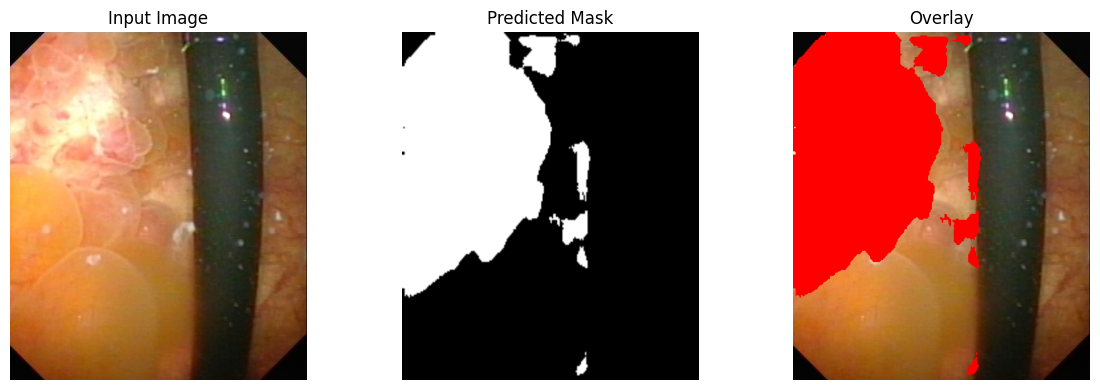

In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


image_path = "D:/Leko/test2.jpg"
model_path = os.path.join(Config.saved_model_dir, "Unet+++Resnet34.pth")  # 保存模型的位置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = smp.UnetPlusPlus(
    encoder_name="resnet50",
    encoder_weights=None,  
    in_channels=3,
    classes=1,
    activation=None
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


transform = A.Compose([
    A.Resize(Config.img_size, Config.img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
original_size = (image_rgb.shape[1], image_rgb.shape[0])  # 原始尺寸 (w, h)

augmented = transform(image=image_rgb)
input_tensor = augmented["image"].unsqueeze(0).to(device)

with torch.no_grad(), torch.cuda.amp.autocast():
    pred = model(input_tensor)
    pred_sigmoid = torch.sigmoid(pred)
    pred_mask = (pred_sigmoid > 0.5).float().squeeze().cpu().numpy()


pred_mask_resized = cv2.resize(pred_mask, original_size)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
overlay = image_rgb.copy()
overlay[pred_mask_resized > 0.5] = [255, 0, 0]  # 将掩码区域涂红
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
